In [1]:
import sys
import os
import struct
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root, 'code'))
from plotting import plot_utils, summary_plots, load_fits, plot_prf_params
plot_utils.set_plotting_defaults()
from utils import roi_utils, nsd_utils, default_paths, stats_utils

In [2]:
# Load results of the fitting procedure

subject = 1
volume_space=True
# fitting_types = ['semantic_discrim_raw','gabor_solo_ridge_12ori_8sf','sketch_tokens', 'alexnet_all_conv']
fitting_types = ['semantic_animacy','semantic_indoor_outdoor']

nf = [0,0]
discrim = []
outlist = []
root = os.path.dirname(os.path.dirname(os.getcwd()))
for fi, fitting_type in enumerate(fitting_types):
    out, fig_save_folder = load_fits.load_fit_results(subject, volume_space, fitting_type, \
                                                      n_from_end=nf[fi], root=root, verbose=True);
#     load_fits.print_output_summary(out)
    print(out['which_prf_grid'])
    print(out['up_to_sess'])
    discrim.append(out['discrim_each_axis'])
    outlist.append(out)
    
if not os.path.exists(fig_save_folder):
    os.makedirs(fig_save_folder)

loading from /user_data/mmhender/imStat/model_fits/S01/semantic_animacy/Nov-22-2021_1813_40/all_fit_params

dict_keys(['subject', 'volume_space', 'fitting_type', 'fitting_type2', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'aperture', 'aperture_rf_range', 'which_prf_grid', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'zscore_in_groups', 'ridge', 'debug', 'up_to_sess', 'single_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'corr_each_feature', 'discrim_each_axis', 'semantic_discrim_type'])
5
40
loading from /user_data/mmhender/imStat/model_fits/S01/semantic_indoor_outdoor/Nov-22-2021_1829_55/all_fit_params

dict_keys(['subject', 'volume_space', 'fitting_type', 'fitting_type2', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'aperture', 'aperture_rf_range', 'which_prf_grid', 'models', 'best_losse

In [36]:
out = torch.load('/user_data/mmhender/imStat/model_fits/S01/semantic_indoor_outdoor/Nov-22-2021_1829_55/all_fit_params')

In [37]:
out['discrim_each_axis'][:,0]

array([ 2.28089952,  2.28089952,  2.28089881, ..., -2.28089929,
       -2.28089929, -2.28089905])

In [3]:
# roi_def = roi_utils.get_combined_rois(subject,include_all=True,include_body=False,volume_space=True,verbose=False) 
roi_def = roi_utils.get_combined_rois(subject,include_all=True,include_body=True,volume_space=True,verbose=False) 

skip_inds = [10,11,15,23]
retlabs, facelabs, placelabs, bodylabs, \
        ret_names, face_names, place_names, body_names = roi_def

nret = len(ret_names)
nface = len(face_names)
nplace = len(place_names)
nbody = len(body_names)    
n_rois = len(ret_names) + len(face_names) + len(place_names) + len(body_names)
roi_names = ret_names+face_names+place_names+body_names

is_ret = np.arange(0, n_rois)<nret
is_face = (np.arange(0, n_rois)>=nret) & (np.arange(0, n_rois)<nret+nface)
is_place = (np.arange(0, n_rois)>=nret+nface) & (np.arange(0, n_rois)<nret+nface+nplace)
is_body = np.arange(0, n_rois)>=nret+nface+nplace


/user_data/mmhender/imStat/code/plotting/summary_plots.py:61: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log');


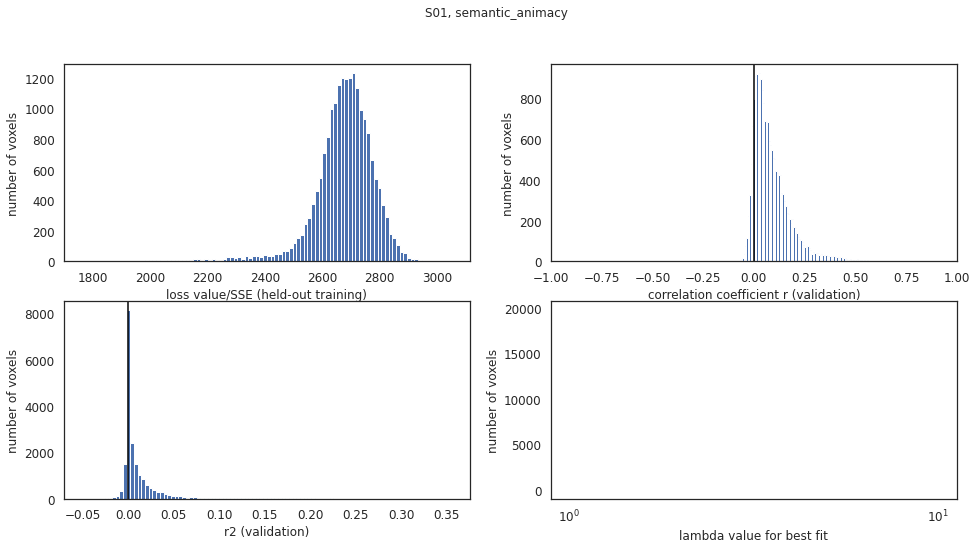

In [4]:
plot_utils.set_all_font_sizes(fs = 12)
summary_plots.plot_perf_summary(subject, fitting_types[0], outlist[0], fig_save_folder=fig_save_folder)

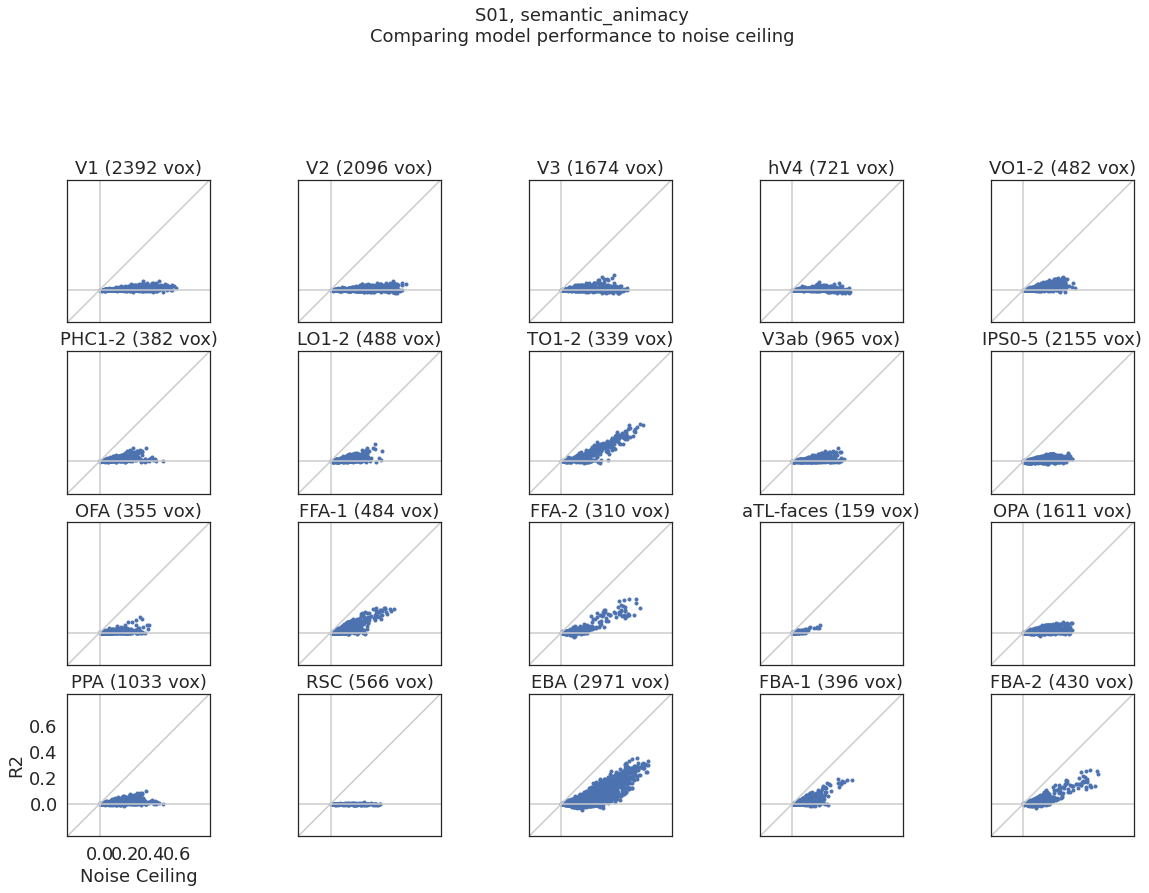

In [5]:
plot_utils.set_all_font_sizes(fs = 18)
summary_plots.plot_r2_vs_nc(subject, fitting_types[0],outlist[0], roi_def=roi_def, skip_inds=skip_inds, \
                            axlims = [-0.25, 0.85], fig_save_folder=fig_save_folder, fig_size=(20,24))

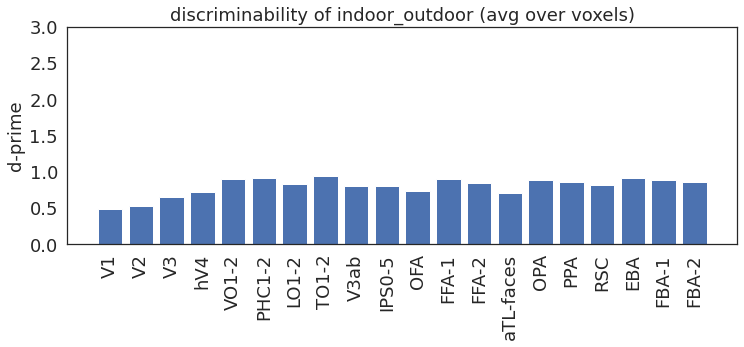

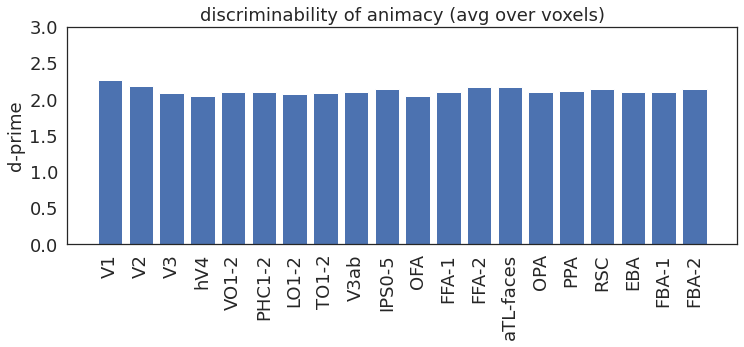

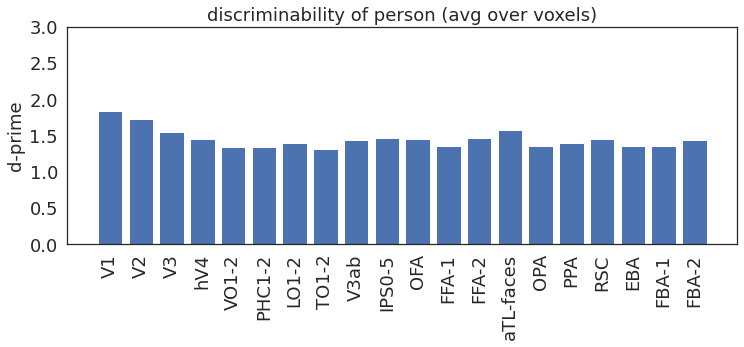

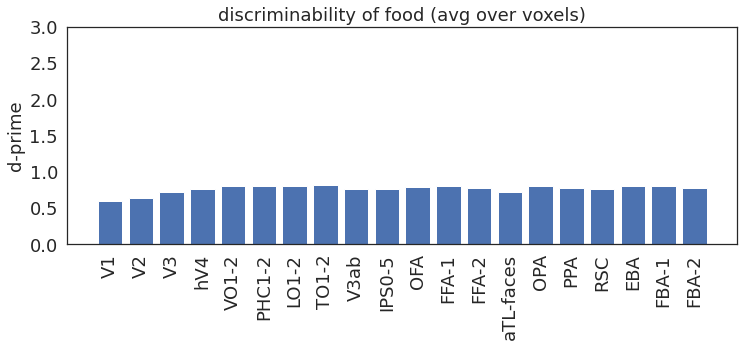

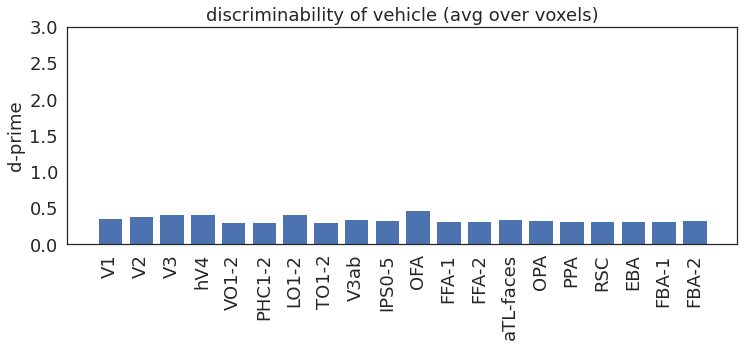

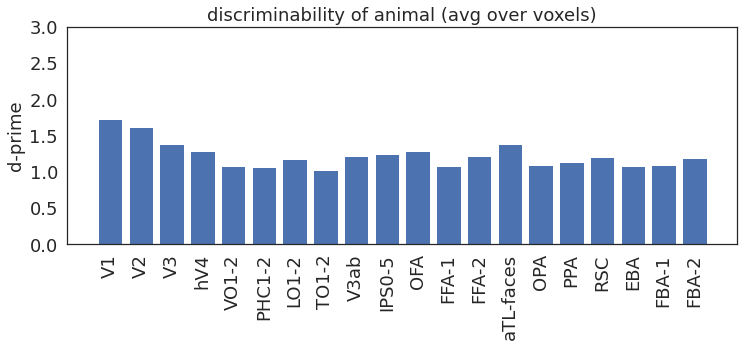

In [6]:
out = outlist[0]

discrim_each_axis = out['discrim_each_axis']
discrim_type_list = ['indoor_outdoor','animacy','person','food','vehicle','animal']
n_sem_axes = len(discrim_type_list)
mean_discrim_each_roi = np.zeros((n_rois, n_sem_axes))

for rr in range(n_rois):
    if rr not in skip_inds:
        if is_ret[rr]:
            inds_this_roi = retlabs==rr
        elif is_face[rr]:
            inds_this_roi = facelabs==(rr-nret)
        elif is_place[rr]:
            inds_this_roi = placelabs==(rr-nret-nface)
        elif is_body[rr]:
            inds_this_roi = bodylabs==(rr-nret-nface-nplace)
        mean_discrim_each_roi[rr,:] = np.mean(np.abs(discrim_each_axis[inds_this_roi,:]), axis=0)
    else:
        mean_discrim_each_roi[rr,:] = np.nan


for aa, discrim_type in enumerate(discrim_type_list):
    plt.figure(figsize=(12,4));
    inds2use = ~np.isin(np.arange(n_rois), skip_inds)
#     inds2use = ~np.isnan(dprime_vals[:,aa])
    n_rois_plot = np.sum(inds2use)
    plt.bar(np.arange(n_rois_plot),mean_discrim_each_roi[inds2use,aa])
    plt.xticks(np.arange(n_rois_plot), labels=np.array(roi_names)[inds2use], rotation=90);
    plt.ylabel('d-prime')
    plt.title('discriminability of %s (avg over voxels)'%discrim_type)
    plt.ylim([0,3.0])

In [28]:
# Make plots in pycortex 

out = outlist[0]

import cortex

port=43333

vox2plot = out['val_r2'][:,0]>-100

best_ecc_deg, best_angle_deg, best_size_deg = plot_prf_params.get_prf_pars_deg(out);
names = ['pRF eccentricity', 'pRF angle', 'pRF size']
maps = [best_ecc_deg, best_angle_deg, best_size_deg]
cmaps = ['PRGn', 'Retinotopy_RYBCR', 'PRGn']
mins = [0,0,0]
maxes = [10, 360, 8]


maps += [np.sqrt(out['val_r2'][:,0])]
names += ['semantic model R2 (sqrt)']
cmaps += ['PuBu']
mins += [0]
maxes += [0.6]

wts = out['best_params'][1]
maps += [wts[:,0,0]]
names += ['semantic feature weight']
cmaps += ['PuBu']
mins += [-0.6]
maxes += [0.6]

discrim_each_axis = out['discrim_each_axis']
discrim_type_list = ['indoor_outdoor','animacy','person','food','vehicle','animal']
n_sem_axes = len(discrim_type_list)
maps += [discrim_each_axis[:,dd] for dd in range(n_sem_axes)]
names += ['dprime: %s'%dd for dd in discrim_type_list]
cmaps += ['RdBu' for dd in range(n_sem_axes)]
mins += [-1.5 for dd in range(n_sem_axes)]
maxes += [1.5 for dd in range(n_sem_axes)]



plot_utils.plot_maps_pycortex(maps, names, subject, out, roi_def=roi_def, vox2plot=vox2plot, \
                              fitting_type=fitting_type, \
                              port=port, cmaps=cmaps, mins=mins, maxes=maxes)

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt


Data is in 3d volume space
navigate browser to: 127.0.0.1:43333
Started server on port 43333


In [24]:
best_vox = np.argmin(discrim_each_axis[:,1])
print(discrim_each_axis[best_vox,1])
mm = out['best_params'][5][best_vox,0]
out['models'][mm,:]
print(mm)

-7.324682235717773
129


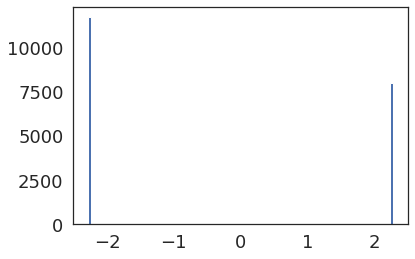

In [32]:
plt.figure();
discrim_each_axis = outlist[1]['discrim_each_axis']
plt.hist(discrim_each_axis[:,0],100);

In [34]:
np.unique(discrim_each_axis[:,0])

array([-2.28104854, -2.28094339, -2.28091431, -2.28090858, -2.28090835,
       -2.28090739, -2.28090692, -2.28090668, -2.28090596, -2.28090525,
       -2.28090501, -2.28090477, -2.28090286, -2.28090262, -2.28090191,
       -2.28090167, -2.28090143, -2.28090119, -2.28090096, -2.28090072,
       -2.28090048, -2.28090024, -2.2809    , -2.28089976, -2.28089952,
       -2.28089929, -2.28089905, -2.28089881, -2.28089857, -2.28089833,
       -2.28089809, -2.28089786, -2.28089762, -2.28089738, -2.28089714,
       -2.2808969 , -2.28089666, -2.28089643, -2.28089619, -2.28089547,
       -2.28089523, -2.28089476, -2.28089261, -2.28089213, -2.28089166,
       -2.28089118, -2.28088784, -2.28087616, -2.28087592, -2.28086758,
       -2.28085804, -2.28036952,  2.28079867,  2.28082681,  2.28084707,
        2.28085995,  2.28088045,  2.28088474,  2.28089213,  2.28089261,
        2.28089404,  2.28089523,  2.28089547,  2.28089595,  2.28089619,
        2.28089643,  2.28089666,  2.2808969 ,  2.28089714,  2.28

In [23]:
neach = [2943, 57]
realdat = np.concatenate([np.ones((neach[0],1)), np.zeros((neach[1],1))],axis=0)
preddat = realdat
from utils import stats_utils
stats_utils.get_dprime(np.squeeze(preddat),np.squeeze(realdat))

7.175829344575894

In [35]:

neach = [2247, 753]
realdat = np.concatenate([np.ones((neach[0],1)), np.zeros((neach[1],1))],axis=0)
preddat = realdat
from utils import stats_utils
stats_utils.get_dprime(np.squeeze(preddat),np.squeeze(realdat))

7.175829344575894

In [27]:
np.max(wts)

0.56407934

In [21]:
stats_utils.get_dprime

<function utils.stats_utils.get_dprime(predlabs, reallabs, un=None)>

In [11]:
[1842, 1158]

2496

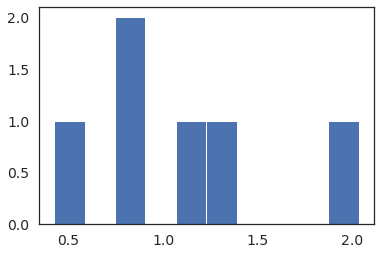

In [13]:
plt.figure();
plt.hist(np.abs(discrim[0][1,:]),10);

In [14]:
np.unique(discrim[0][1,:])

array([-2.03320932, -1.33806705, -1.1055913 ,  0.42349592,  0.84657365,
        0.89161772])

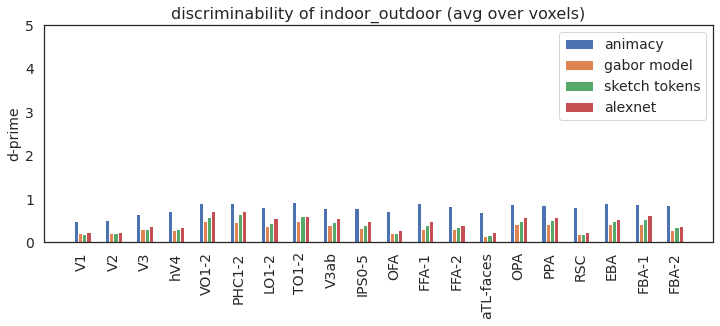

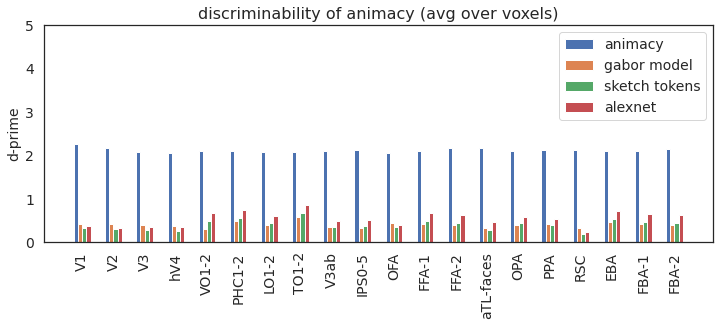

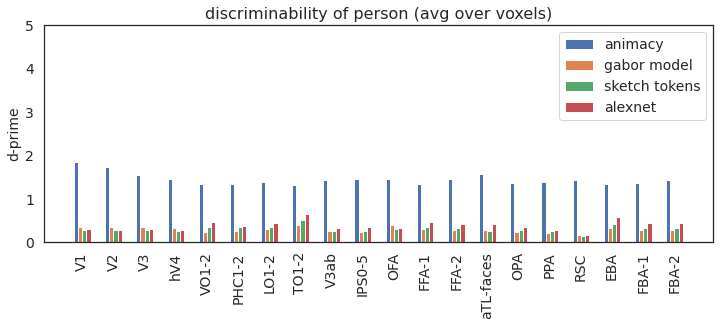

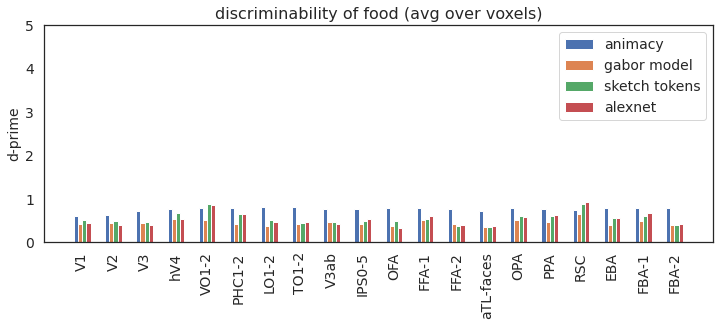

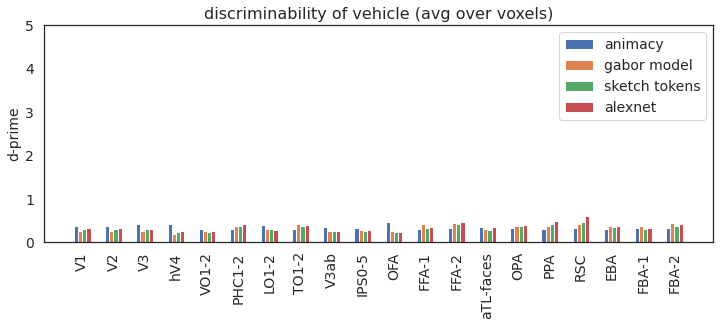

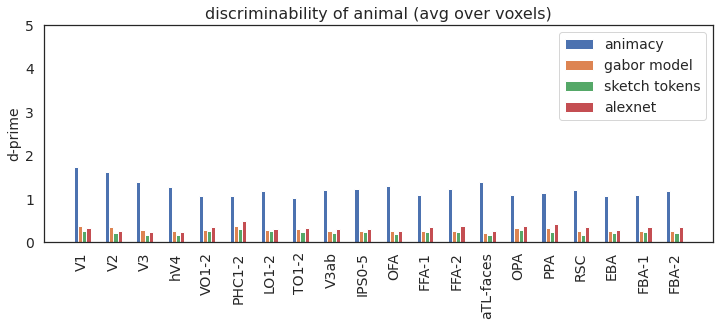

In [6]:

# fitting_names = ['raw data','gabor model','sketch tokens','alexnet']
fitting_names = ['animacy','gabor model','sketch tokens','alexnet']

discrim_type_list = ['indoor_outdoor','animacy','person','food','vehicle','animal']
n_sem_axes = len(discrim_type_list)
mean_discrim_each_roi = np.zeros((len(fitting_types),n_rois, n_sem_axes))

for ff in range(len(fitting_types)):
    for rr in range(n_rois):
        if rr not in skip_inds:
            if is_ret[rr]:
                inds_this_roi = retlabs==rr
            elif is_face[rr]:
                inds_this_roi = facelabs==(rr-nret)
            elif is_place[rr]:
                inds_this_roi = placelabs==(rr-nret-nface)
            elif is_body[rr]:
                inds_this_roi = bodylabs==(rr-nret-nface-nplace)
            mean_discrim_each_roi[ff,rr,:] = np.mean(np.abs(discrim[ff][inds_this_roi,:]), axis=0)
        else:
            mean_discrim_each_roi[ff,rr,:] = np.nan

bar_jitters = np.linspace(-0.2, 0.2,len(fitting_types))
bar_width = np.diff(bar_jitters[0:2])[0]
for aa, discrim_type in enumerate(discrim_type_list):
    plt.figure(figsize=(12,4));
    inds2use = ~np.isin(np.arange(n_rois), skip_inds)
#     inds2use = ~np.isnan(dprime_vals[:,aa])
    n_rois_plot = np.sum(inds2use)
    for fi in range(len(fitting_types)):
        plt.bar(np.arange(n_rois_plot)+bar_jitters[fi],mean_discrim_each_roi[fi,inds2use,aa],\
                width=bar_width)
    plt.xticks(np.arange(n_rois_plot), labels=np.array(roi_names)[inds2use], rotation=90);
    plt.ylabel('d-prime')
    plt.title('discriminability of %s (avg over voxels)'%discrim_type)
    plt.ylim([0,5.0])
    
    plt.legend(fitting_names)

In [4]:
# Make plots in pycortex for variance partitioning analysis

import cortex
import copy
port=33333

# out = outlist[0]
# fitting_type = fitting_types[0]

maps = []
names = []
cmaps = []
mins = []
maxes =[]

vox2plot = np.ones((out['discrim_each_axis'].shape[0],))==1
# vox2plot = out['val_r2'][:,0]>0

# best_ecc_deg, best_angle_deg, best_size_deg = plot_prf_params.get_prf_pars_deg(out);
# print([np.max(best_ecc_deg), np.max(best_size_deg)])
# names = ['pRF eccentricity', 'pRF angle', 'pRF size']
# maps = [best_ecc_deg, best_angle_deg, best_size_deg]
# cmaps = ['PRGn', 'Retinotopy_RYBCR', 'PRGn']
# mins = [0,0,0]
# maxes = [7, 360, 8.4]


# maps += [np.sqrt(out['val_r2'][:,0])]
# names += ['sketch tokens model R2 (sqrt)']
# cmaps += ['PuBu']
# mins += [0]
# maxes += [0.6]

for fi, fitting_type in enumerate(fitting_types):
    out = outlist[fi]
    discrim_each_axis = copy.deepcopy(out['discrim_each_axis'])
    discrim_type_list = ['indoor_outdoor','animacy','person','food','vehicle','animal']
    n_sem_axes = len(discrim_type_list)
    maps += [discrim_each_axis[:,dd] for dd in range(n_sem_axes)]
    names += ['%s: dprime: %s'%(fitting_type, dd) for dd in discrim_type_list]
    cmaps += ['RdBu' for dd in range(n_sem_axes)]
    mins += [-1.5 for dd in range(n_sem_axes)]
    maxes += [1.5 for dd in range(n_sem_axes)]

plot_utils.plot_maps_pycortex(maps, names, subject, out, roi_def=roi_def, vox2plot=vox2plot, \
                              fitting_type=fitting_types[0], \
                              port=port, cmaps=cmaps, mins=mins, maxes=maxes)

Data is in 3d volume space
navigate browser to: 127.0.0.1:33333
Started server on port 33333
